In [1]:
%matplotlib inline

In [2]:
import json
from glob import glob
import time
import urllib
import functools
import os
from os.path import basename, dirname, join

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import dateutil.parser
from tqdm import tqdm_notebook
from joblib import Parallel, delayed

In [4]:
def parse_lhcb_gps_time(gps_time):
    # gps time is given with microsecond precision in LHCb
    return datetime.datetime.fromtimestamp(gps_time*1e-6)

In [5]:
@functools.lru_cache(maxsize=10240)
def get_run_info(run_number):
    response = urllib.request.urlopen(f'http://lbrundb.cern.ch/api/run/{run_number}')
    data = json.loads(response.read())
    run_start_time = dateutil.parser.parse(data['starttime'])
    run_end_time = dateutil.parser.parse(data['endtime'])
    return run_start_time, run_end_time

# Build the run info cache
# _ = Parallel(n_jobs=20, backend='threading')(
#     delayed(get_run_info)(run_number) for run_number in os.listdir('output/BEAMGAS/')
# )

In [6]:
def load(filename):
    df = pd.read_json(filename)
    df.columns = ['i', 'gps_time', 'run_number', 'orbit_number', 'event_number', 'detector_status']
    df['gps_time'] = df.gps_time.apply(parse_lhcb_gps_time)
    return df

In [7]:
def plot_time(stream, run_number, n_bins=100, inspect_end=False):
    run_start_time, run_end_time = get_run_info(run_number)

    plt.figure(figsize=(14, 7))
    all_dfs = []
    for i, fn in enumerate(glob(f'output/{stream}/{run_number}/*.json')):
        df = load(fn)
        histtype = 'step' if i < 10 else 'stepfilled'
        df.gps_time.hist(bins=n_bins, label=basename(fn), normed=True, histtype=histtype)
        all_dfs.append(df)
    plt.axvline(run_start_time, c='k', ls='--', label='Start of run')
    plt.axvline(run_end_time, c='k', ls='dashdot', label='End of run')
    plt.legend(loc='lower left')
    plt.xlabel(f'Time (run ended at {run_end_time})')

    all_dfs = pd.concat(all_dfs, ignore_index=True)
    assert len(all_dfs.run_number.unique()) == 1, run_number
    title = []

    data_start_time = all_dfs.gps_time.min()
    if run_start_time > all_dfs.gps_time.min():
        title.append(f'undeflows with {np.count_nonzero(run_start_time > all_dfs.gps_time)} events '
                     f'by {(run_start_time-data_start_time).total_seconds()} seconds')

    data_end_time = all_dfs.gps_time.max()
    if all_dfs.gps_time.max() > run_end_time:
        title.append(f'overflows with {np.count_nonzero(all_dfs.gps_time > run_end_time)} events '
                     f'by {(data_end_time-run_end_time).total_seconds():.3f} seconds')

    plt.title(f'Run {run_number}, {stream} stream ' + ' and '.join(title))
    
    if inspect_end:
        plt.yscale('log')
        plt.ylim(0.1, plt.ylim()[1])
        _, x_stop = plt.xlim()
        _, x_run_stop = plt.xlim(run_start_time, run_end_time)
        x_stop = x_stop-0.00205
        plt.xlim(2*x_run_stop-x_stop, x_stop)

    plt.gcf().patch.set_alpha(0)

In [8]:
for data_type in tqdm_notebook(glob('output/*/')):
    for run_number in os.listdir(data_type):
        run_start_time, run_end_time = get_run_info(run_number)
        for fn in glob(join(data_type, run_number, '*.json')):
            df = load(fn)
            if run_start_time > df.gps_time.min() or df.gps_time.max() > run_end_time:
                print(f'WARNING: Out of run events found in {fn}')

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
json.loads(urllib.request.urlopen(f'http://lbrundb.cern.ch/api/run/192339').read())

{'LHCState': 'PHYSICS',
 'activity': 'COLLISION',
 'beamenergy': 6500.0,
 'beamgasTrigger': '1',
 'betaStar': '3.03',
 'conddbTag': 'cond-20170510',
 'dddbTag': 'dddb-20150724',
 'destination': 'OFFLINE',
 'endlumi': 118366.5887677,
 'endtime': '2017-05-31T00:16:42',
 'fillid': 5730,
 'hlt2CalibVersions': 'OT_Calib:v390|Rich1_Readout:v5|Rich2_Readout:v7|OT_ModulesCalib:v0|Muon_MuonGlobal:v2|Muon_MuonModules:v2|Rich1_MirrorAlign:v5|Rich2_MirrorAlign:v5|Rich1_HpdAlign:v53042|Rich2_HpdAlign:v53049|Rich1_Calib:v30607|Rich2_Calib:v30518',
 'hlt2TriggerConfig': 'TriggerConfig:Physics_1702__&HLT2|MooreOnlineV:MooreOnline_v26r4|MooreV:Moore_v26r4|OnlineV:Online_v6r4|HLTType:Physics_pp_June2017_1|TCKLabel:Hlt2. Physics pp June 2017. 800b. with SumEt Prev. no Herschel. LBHLT-342 (0x21511702)',
 'hlt2TriggerSettings': 'TCK:558962434|L0Type:PHYSICS_May2017_TCK1702_0x1702|LumiTrigger:1|LumiBBRate:1|BeamGasTrigger:1|NoBiasTrigger:1|NoBiasRate:0.2|CondDBTag:cond-20170510|DDDBTag:dddb-20150724|OnlDBTa

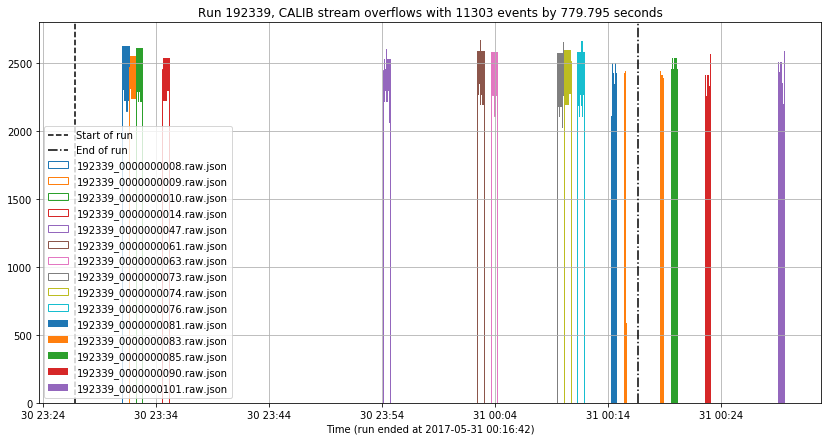

In [10]:
stream = 'CALIB'
run_number = '192339'

plot_time(stream, run_number)
plt.savefig(f'plots/{run_number}_{stream}.pdf', bbox_inches='tight')

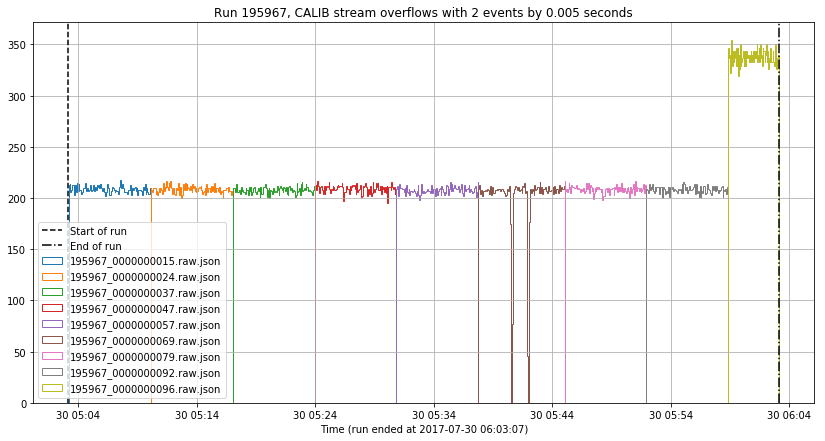

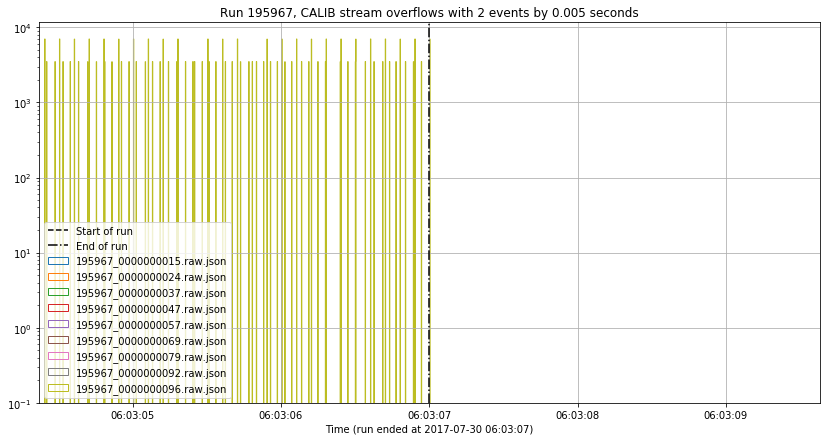

In [11]:
stream = 'CALIB'
run_number = '195967'

plot_time(stream, run_number)
plt.savefig(f'plots/{run_number}_{stream}.pdf', bbox_inches='tight')

plot_time(stream, run_number, inspect_end=True, n_bins=100000)
plt.savefig(f'plots/{run_number}_{stream}_end_only.pdf', bbox_inches='tight')

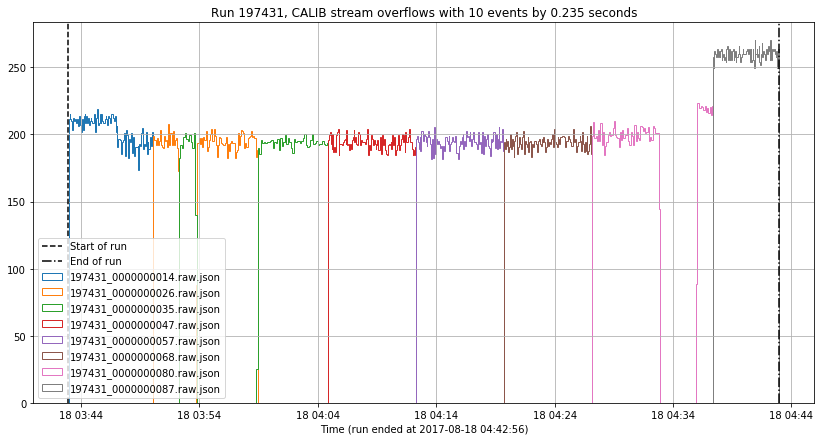

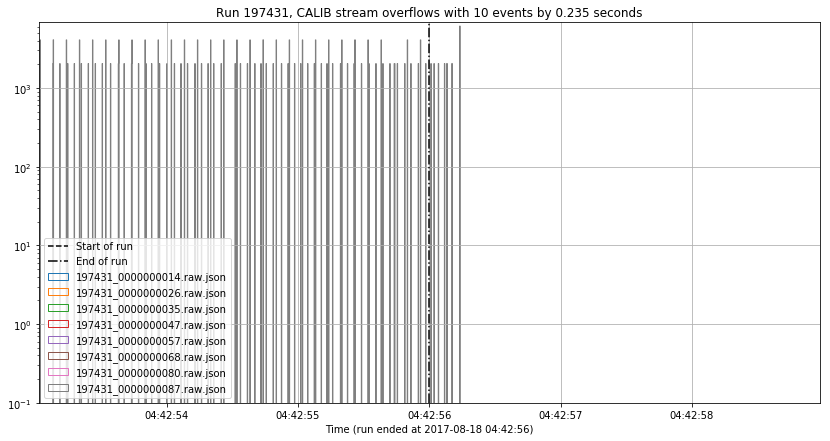

In [12]:
stream = 'CALIB'
run_number = '197431'

plot_time(stream, run_number)
plt.savefig(f'plots/{run_number}_{stream}.pdf', bbox_inches='tight')

plot_time(stream, run_number, inspect_end=True, n_bins=100000)
plt.savefig(f'plots/{run_number}_{stream}_end_only.pdf', bbox_inches='tight')

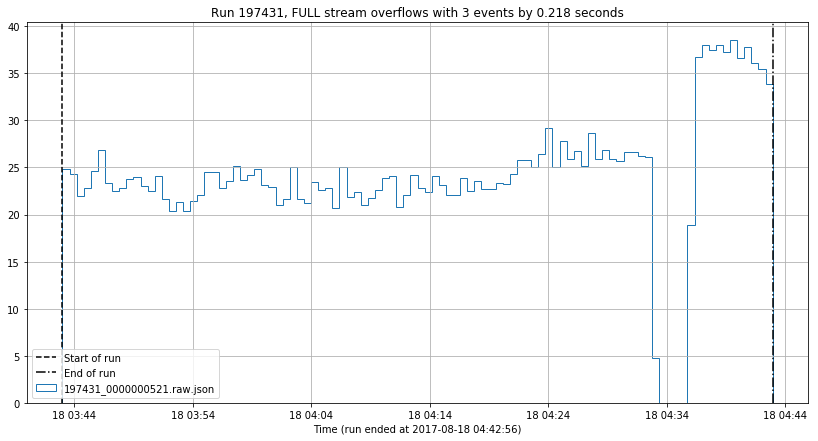

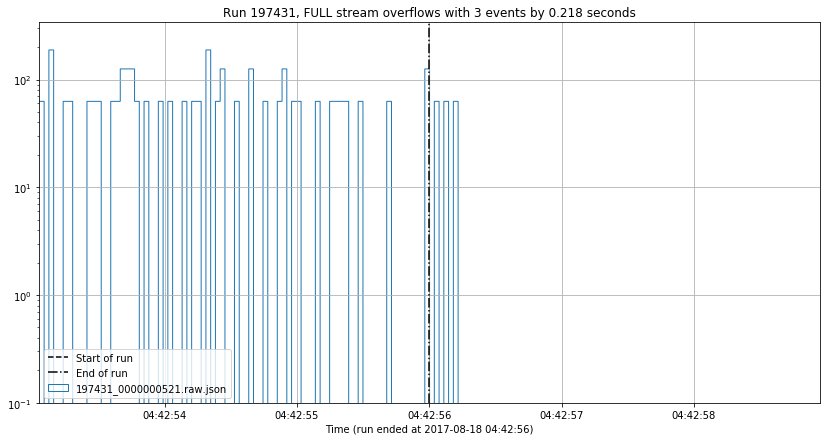

In [13]:
stream = 'FULL'
run_number = '197431'

plot_time(stream, run_number)
plt.savefig(f'plots/{run_number}_{stream}.pdf', bbox_inches='tight')

plot_time(stream, run_number, inspect_end=True, n_bins=100000)
plt.savefig(f'plots/{run_number}_{stream}_end_only.pdf', bbox_inches='tight')